# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [36]:
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';', 
                     low_memory=False, index_col='LNR')
customers = pd.read_csv('./arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', 
                        low_memory=False, index_col='LNR')

In [ ]:
azdias.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
customers.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [6]:
print(azdias.shape)
azdias.head()

(891221, 365)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [7]:
mailout = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', 
                      sep=';', index_col='LNR')
test = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TEST.csv', 
                      sep=';', index_col='LNR')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
print(mailout.shape)
mailout.head()

(42962, 366)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [9]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Exploratory analysis

### Dealing with unknown values

Columns with the broad information about the customers have no missing values.

In [10]:
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].isnull().sum()

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64

Other columns are common for the 4 datasets: azdias, customers, mailout_train and testm data. Here is the percentage of missing values in each column

In [16]:
# ----- check missing values
azdias_nulls = azdias.isnull().sum()
customers_nulls = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1).isnull().sum()
mailout_nulls = mailout.drop("RESPONSE", axis=1).isnull().sum()
test_nulls = test.isnull().sum()
#
acmt_nulls = pd.concat([azdias_nulls/len(azdias), customers_nulls/len(customers),
                        mailout_nulls/len(mailout), test_nulls/len(test)], axis=1)
acmt_nulls.columns = ['azdias', 'customers', 'mailout', 'test']
#
display(HTML('<H3> Prozent of missing values in each dataset </H3> '))
acmt_nulls

,azdias,customers,mailout,test
AGER_TYP,0.000000,0.000000,0.000000,0.000000
AKT_DAT_KL,0.082470,0.243128,0.162213,0.160834
ALTER_HH,0.082470,0.243128,0.162213,0.160834
ALTER_KIND1,0.909048,0.938607,0.953727,0.953004
ALTER_KIND2,0.966900,0.973389,0.982403,0.982210
ALTER_KIND3,0.993077,0.993347,0.995950,0.995307
ALTER_KIND4,0.998648,0.998769,0.999046,0.999089
ALTERSKATEGORIE_FEIN,0.295041,0.270501,0.189819,0.189527
ANZ_HAUSHALTE_AKTIV,0.104517,0.260509,0.181020,0.178064
ANZ_HH_TITEL,0.108848,0.271899,0.191937,0.190180


The table above shows that nearly each column has explicitely unknown values (empty strings in CSV file). At the same time, from data documentation we know, that uknown values are encoded as either 0 or -1. Let us keep our notations unified and replace all of them with 0.

In some columns 9 also means missing values, but I will leave this for the moment.

In [12]:
replace_NA_dict = {-1: 0}

In [13]:
azdias = azdias.fillna(0).replace(replace_NA_dict)
display(azdias.head())
azdias.to_pickle('arvato_data/azdias_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [17]:
customers = customers.fillna(0).replace(replace_NA_dict)
display(customers.head())
customers.to_pickle('arvato_data/customers_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [18]:
mailout = mailout.fillna(0).replace(replace_NA_dict)
display(mailout.head())
mailout.to_pickle('arvato_data/mailout_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

In [19]:
test = test.fillna(0).replace(replace_NA_dict)
display(test.head())
test.to_pickle('arvato_data/test_cleaned.pkl')

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA1

### Feature Selection before Customer Segmentation

In Part 1 - Customer Segmentation Report - the unsupervised algorithms should be built on a small number of relevant features. In the absence of domain-specific knowledge, I rely on Machine Learning algorithms to perform feature selection. 

Strictly speaking, before applying any ML algorithm, one should think about 

* a way of dealing with categorical features
* feature normalization

With all 367 features being categorical (or ordered categorical) this is a problem on itself.

##### Preparing data for supervised learning

Manual exploratory analysis for 367 columns is infeasible for the time of the capstone project. So I will try to determine with ML methods, which columns are most relevant for distinguishing customers from general population. 

I combine the azdias and customers datasets and reformulate this problem as superviseed learning.
I define the binary variable 'is_customer', so the problem becomes a binary classification.

In [3]:
if 'azdias' not in dir():
    azdias = pd.read_pickle('arvato_data/azdias_cleaned.pkl')
print('adzias', azdias.shape)

adzias (891221, 365)


In [4]:
if 'customers' not in dir():
    customers = pd.read_pickle('arvato_data/customers_cleaned.pkl')
print('customers',customers.shape)

customers (191652, 368)


In [16]:
is_customer = pd.concat([pd.Series(1, index=customers.index),
                         pd.Series(0, index=azdias.index)], axis=0, verify_integrity=True, copy=True)
#customers['is_customer'] = 1
#azdias['is_customer'] = 0
data = pd.concat([customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1),
                  azdias], axis=0, verify_integrity=True, copy=True)
#data.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [18]:
is_customer.head()

LNR
9626      1
9628      1
143872    1
143873    1
143874    1
dtype: int64

In [19]:
data.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_

In [20]:
# shuffle data
is_customer = is_customer.sample(frac=1.0)
data = data.loc[is_customer.index]

##### Random forest

Fortunately tree-based models like RandomForest or GradientBoosting Regressor are insensitive to feature scaling and can work with the data as they are.  The python implementations (here, scikit-learn) also provides automatical calculation of feature importance. 

I keep the categorical features in numerical form as they are. This is not ideal, but enough to estimate importance of each feature. Those are the features that distinguish customers from general population.

In [ ]:
object_columns = data.select_dtypes(include='object').columns.tolist()
object_columns

In [16]:
data[object_columns].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,,,
714757,6D,6,35,0,1992-02-10 00:00:00,W
512398,0,0,0,0,0,0
5435,0,0,0,0,0,0
669421,6B,6,43,D19_LEBENSMITTEL,1992-02-10 00:00:00,W
914973,8C,8,54,D19_VOLLSORTIMENT,1992-02-10 00:00:00,W


In [28]:
from sklearn.preprocessing import LabelEncoder
les = dict()
for colu in object_columns:
    les[colu] = LabelEncoder().fit(data[colu].astype(str))
    data[colu] = les[colu].transform(data[colu].astype(str))

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=600, min_samples_leaf=64)

In [44]:
%%time
rf.fit(data, is_customer)

CPU times: user 1h 7min 18s, sys: 2.45 s, total: 1h 7min 20s
Wall time: 1h 7min 23s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
feature_importances = pd.Series(rf.feature_importances_, index=data.columns).sort_values(ascending=False)
feature_importances.head(25)

D19_SOZIALES                  0.105380
D19_KONSUMTYP_MAX             0.031586
ALTERSKATEGORIE_GROB          0.029531
D19_KONSUMTYP                 0.025935
VK_ZG11                       0.018313
VK_DISTANZ                    0.017073
CJT_TYP_6                     0.013589
CJT_TYP_5                     0.012690
EXTSEL992                     0.012447
CJT_TYP_3                     0.012066
PRAEGENDE_JUGENDJAHRE         0.011933
EINGEZOGENAM_HH_JAHR          0.011733
AKT_DAT_KL                    0.010280
VK_DHT4A                      0.010043
CJT_TYP_4                     0.009989
RT_SCHNAEPPCHEN               0.009679
CJT_TYP_1                     0.007718
LP_LEBENSPHASE_FEIN           0.007088
GFK_URLAUBERTYP               0.007000
FINANZ_ANLEGER                0.006995
RT_KEIN_ANREIZ                0.006969
LP_STATUS_FEIN                0.006508
KOMBIALTER                    0.006485
FINANZ_VORSORGER              0.006244
ANZ_STATISTISCHE_HAUSHALTE    0.006235
dtype: float64

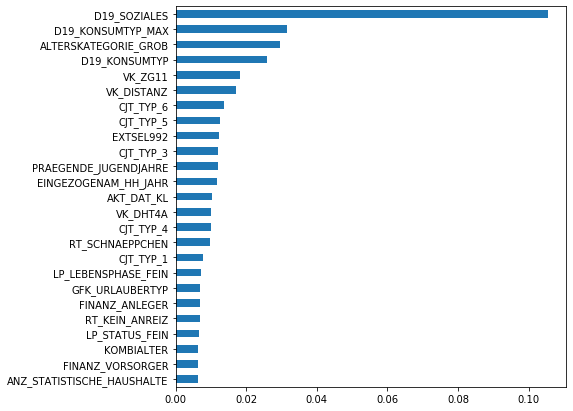

In [50]:
feature_importances.head(25)[::-1].plot.barh(figsize=(7,7));

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

##### Read cleaned data

In [5]:
if 'adzias' not in dir():
    azdias = pd.read_pickle('arvato_data/azdias_cleaned.pkl')
print('adzias', azdias.shape)

adzias (891221, 365)


In [29]:
if 'customers' not in dir():
    customers = pd.read_pickle('arvato_data/customers_cleaned.pkl')
print('customers',customers.shape)

customers (191652, 368)


In [16]:
is_customer = pd.concat([pd.Series(1, index=customers.index),
                         pd.Series(0, index=azdias.index)], axis=0, verify_integrity=True, copy=True)
#customers['is_customer'] = 1
#azdias['is_customer'] = 0
data = pd.concat([customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1),
                  azdias], axis=0, verify_integrity=True, copy=True)
#data.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

## Compare distributions for the top-10 features

In [ ]:
#data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})

In [56]:
# tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer',
#                                                                                  colu: 'n_people'}).reset_index()
# for i in [0,1]:
#     tmp.loc[tmp.is_customer==i, 'percent_people'] = \
#               tmp.loc[tmp.is_customer==i, 'n_people']/tmp.loc[tmp.is_customer==i, 'n_people'].sum(axis=0)
# display(tmp)

In [63]:
top10_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3', 'PRAEGENDE_JUGENDJAHRE']
# 'EXTSEL992'  need further clarification
# 'PRAEGENDE_JUGENDJAHRE' rather numerical

In [64]:
import seaborn as sns

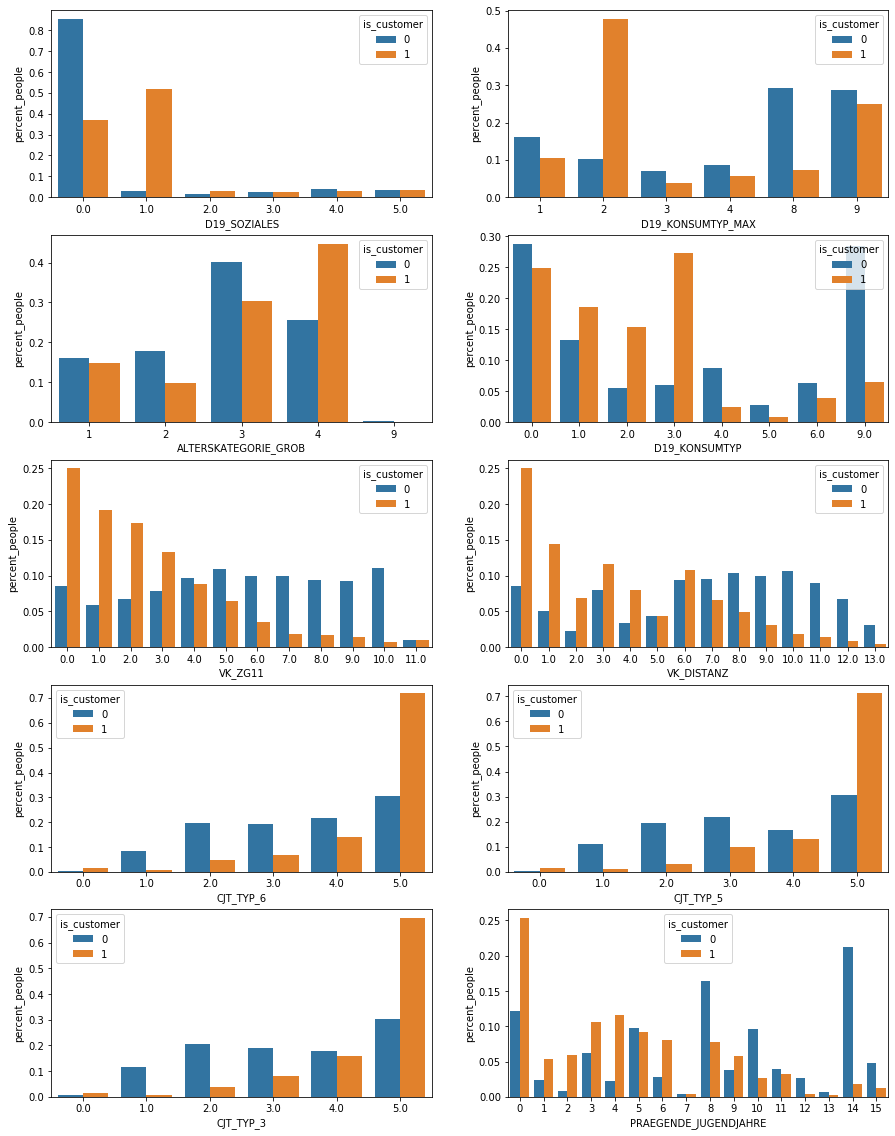

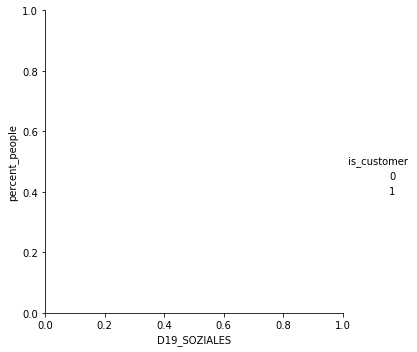

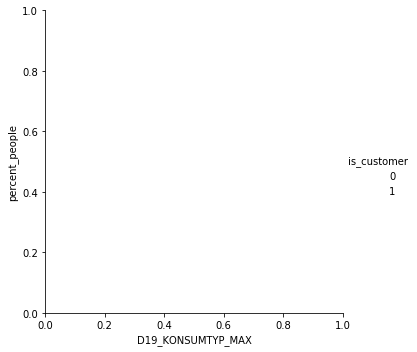

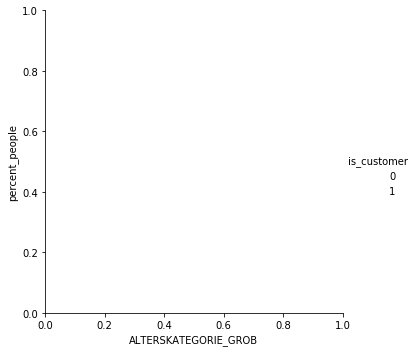

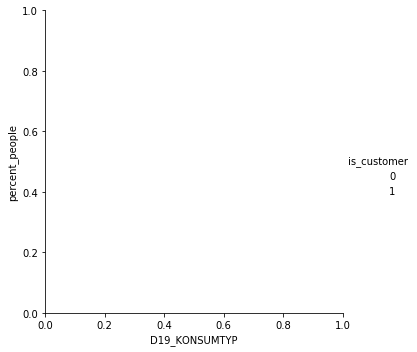

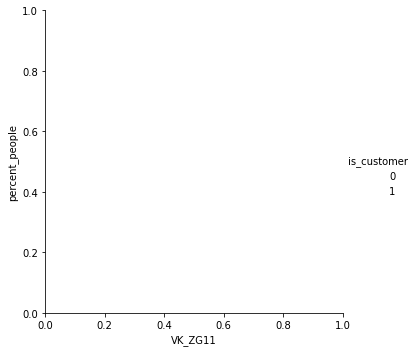

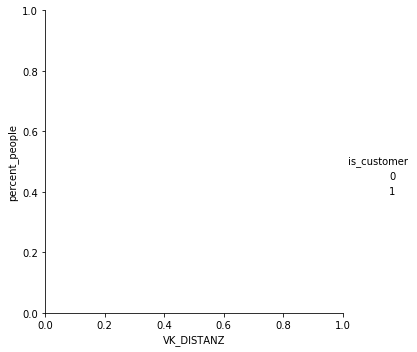

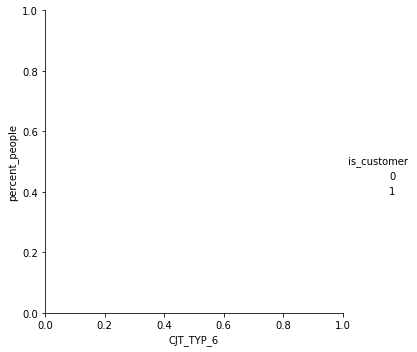

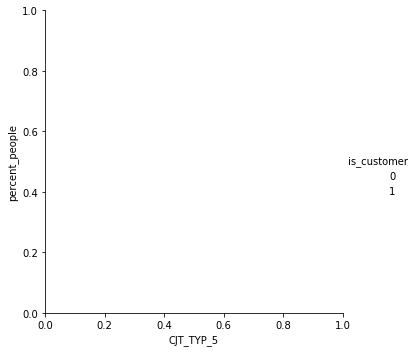

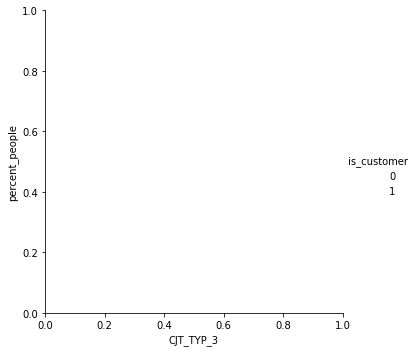

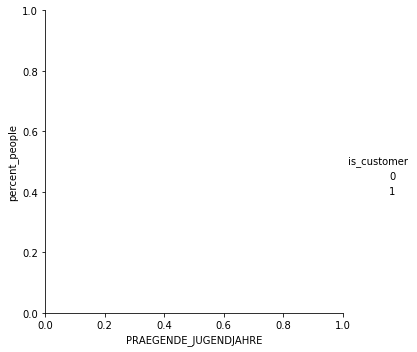

In [68]:
#gr = data.groupby(is_customer)
fig, ax = plt.subplots(5,2, figsize=(15,20))
for i, colu in enumerate(top10_columns):
    n = azdias[colu].nunique()
    # ----- tmp DataFrame:
    # ----- percentage of people for each category, calculated separately for customers and not-customers
    #tmp = gr[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})
    tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(
                        columns={'level_0':'is_customer', colu: 'n_people'}).reset_index()
    
    for c in [0,1]:
        tmp.loc[tmp.is_customer==c, 'percent_people'] = \
                  tmp.loc[tmp.is_customer==c, 'n_people']/tmp.loc[tmp.is_customer==c, 'n_people'].sum(axis=0)
    
    #display(tmp)
    # ----- visualize
    if n<20:
        #tmp.plot.barh(ax=ax[i//2, i%2], title=colu, c='is_customer')
        _ = sns.catplot(ax=ax[i//2, i%2], kind='bar', 
                            x=colu, y='percent_people', hue='is_customer', data=tmp)
    else:
        #tmp.plot.hist(ax=ax[i//2, i%2], title=colu, c='is_customer', bins=100, log=True)
        _ = sns.lineplot(ax=ax[i//2, i%2], lw=3, 
                               x=colu, y='percent_people', hue='is_customer', data=tmp)
display(fig)
plt.close(fig)

In [70]:
#import itertools
#for cc in itertools.combinations(top10_columns, 2):
#    c1, c2 = cc
#    ctable = pd.crosstab(index=azdias[c1], columns=azdias[c2], normalize='all', margins=True)
#    display(ctable)

## Dimensionality Reduction

The most methods of dimensionality reduction (Principal Component Analysis, Factor Analysis) are meaningful for classical numerical features. For categorical features I propose to OHE-encode those and then use the Latent Dirichlet Allocation (LDA). 

Origonally developed to discover topics in text documents, LDA is intrinsically suited to work with high-dimensional sparse data. This exactly corresponds to our data after OHE. 

Simultaneously, the result of LDA can be interpreted as clustering. Each found 'topic' will correspond to cluster.

### OHE  top-N categorical  columns

All clustering algorithms are based on the concept of distance between points. For categorical data this concept is meaningful after applying One-Hot Encoding (OHE) to all categorical columns

In [6]:
top10_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3', 'PRAEGENDE_JUGENDJAHRE']

##### OHE for all categorical values

In [7]:
#data_ohe = data[top10_columns].copy()
##columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
#data_ohe = pd.get_dummies(data_ohe, drop_first=True, columns=top10_columns)
#data_ohe.head()

In [9]:
azdias_ohe = azdias[top10_columns].copy()
#columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
azdias_ohe = pd.get_dummies(azdias_ohe, drop_first=True, columns=top10_columns).astype(int)
print(azdias_ohe.shape) # (,75)
azdias_ohe.head()

(891221, 75)


,D19_SOZIALES_1.0,D19_SOZIALES_2.0,D19_SOZIALES_3.0,D19_SOZIALES_4.0,D19_SOZIALES_5.0,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,VK_ZG11_1.0,VK_ZG11_2.0,VK_ZG11_3.0,VK_ZG11_4.0,VK_ZG11_5.0,VK_ZG11_6.0,VK_ZG11_7.0,VK_ZG11_8.0,VK_ZG11_9.0,VK_ZG11_10.0,VK_ZG11_11.0,VK_DISTANZ_1.0,VK_DISTANZ_2.0,VK_DISTANZ_3.0,VK_DISTANZ_4.0,VK_DISTANZ_5.0,VK_DISTANZ_6.0,VK_DISTANZ_7.0,VK_DISTANZ_8.0,VK_DISTANZ_9.0,VK_DISTANZ_10.0,VK_DISTANZ_11.0,VK_DISTANZ_12.0,VK_DISTANZ_13.0,CJT_TYP_6_1.0,CJT_TYP_6_2.0,CJT_TYP_6_3.0,CJT_TYP_6_4.0,CJT_TYP_6_5.0,CJT_TYP_5_1.0,CJT_TYP_5_2.0,CJT_TYP_5_3.0,CJT_TYP_5_4.0,CJT_TYP_5_5.0,CJT_TYP_3_1.0,CJT_TYP_3_2.0,CJT_TYP_3_3.0,CJT_TYP_3_4.0,CJT_TYP_3_5.0,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
910220,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
910225,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
910226,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
910241,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [31]:
customers_ohe = customers[top10_columns].copy()
#columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
customers_ohe = pd.get_dummies(customers_ohe, drop_first=True, columns=top10_columns).astype(int)
print(customers_ohe.shape) # (,75)
customers_ohe.head()

(191652, 75)


,D19_SOZIALES_1.0,D19_SOZIALES_2.0,D19_SOZIALES_3.0,D19_SOZIALES_4.0,D19_SOZIALES_5.0,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,VK_ZG11_1.0,VK_ZG11_2.0,VK_ZG11_3.0,VK_ZG11_4.0,VK_ZG11_5.0,VK_ZG11_6.0,VK_ZG11_7.0,VK_ZG11_8.0,VK_ZG11_9.0,VK_ZG11_10.0,VK_ZG11_11.0,VK_DISTANZ_1.0,VK_DISTANZ_2.0,VK_DISTANZ_3.0,VK_DISTANZ_4.0,VK_DISTANZ_5.0,VK_DISTANZ_6.0,VK_DISTANZ_7.0,VK_DISTANZ_8.0,VK_DISTANZ_9.0,VK_DISTANZ_10.0,VK_DISTANZ_11.0,VK_DISTANZ_12.0,VK_DISTANZ_13.0,CJT_TYP_6_1.0,CJT_TYP_6_2.0,CJT_TYP_6_3.0,CJT_TYP_6_4.0,CJT_TYP_6_5.0,CJT_TYP_5_1.0,CJT_TYP_5_2.0,CJT_TYP_5_3.0,CJT_TYP_5_4.0,CJT_TYP_5_5.0,CJT_TYP_3_1.0,CJT_TYP_3_2.0,CJT_TYP_3_3.0,CJT_TYP_3_4.0,CJT_TYP_3_5.0,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9626,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9628,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
143872,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
143873,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
143874,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [33]:
assert all(azdias_ohe.columns==customers_ohe.columns)

### Latent Dirichlet Allocation

In [52]:
lda_evaluation = pd.DataFrame(columns=['perplexity_azdias', 'perplexity_customers'], dtype=float)
from sklearn.decomposition import LatentDirichletAllocation
for n in range(5,15):
    lda = LatentDirichletAllocation(n_components=n, batch_size=2**13, verbose=1, max_iter=100, n_jobs=4)
    lda.fit(azdias_ohe)
    lda_evaluation.loc[n,'perplexity_azdias'] = lda.bound_ 
    lda_evaluation.loc[n,'perplexity_customers'] = lda.perplexity(X=customers_ohe)
    display(lda_evaluation)
## PicklingError: Could not pickle the task to send it to the workers.

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100


PicklingError: Could not pickle the task to send it to the workers.

In [10]:
#id2column={i:w for i,w in enumerate(azdias_ohe.columns)}
#id2column

In [25]:
#type(azdias_ohe.values)
#import scipy
#azdias_csr = scipy.sparse.csr_matrix(azdias_ohe) 

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, batch_size=2**12, verbose=1, max_iter=100, n_jobs=-1)
lda.fit(azdias_ohe)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100


In [12]:
#Variational parameters for topic word distribution. 
# Since the complete conditional for topic word distribution is a Dirichlet, components_[i, j] 
# can be viewed as pseudocount that represents the number of times word j was assigned to topic i. 
# It can also be viewed as distribution over the words for each topic after normalization: 
#model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
lda_components = pd.DataFrame(lda.components_, columns=azdias_ohe.columns)
lda_components

,D19_SOZIALES_1.0,D19_SOZIALES_2.0,D19_SOZIALES_3.0,D19_SOZIALES_4.0,D19_SOZIALES_5.0,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,VK_ZG11_1.0,VK_ZG11_2.0,VK_ZG11_3.0,VK_ZG11_4.0,VK_ZG11_5.0,VK_ZG11_6.0,VK_ZG11_7.0,VK_ZG11_8.0,VK_ZG11_9.0,VK_ZG11_10.0,VK_ZG11_11.0,VK_DISTANZ_1.0,VK_DISTANZ_2.0,VK_DISTANZ_3.0,VK_DISTANZ_4.0,VK_DISTANZ_5.0,VK_DISTANZ_6.0,VK_DISTANZ_7.0,VK_DISTANZ_8.0,VK_DISTANZ_9.0,VK_DISTANZ_10.0,VK_DISTANZ_11.0,VK_DISTANZ_12.0,VK_DISTANZ_13.0,CJT_TYP_6_1.0,CJT_TYP_6_2.0,CJT_TYP_6_3.0,CJT_TYP_6_4.0,CJT_TYP_6_5.0,CJT_TYP_5_1.0,CJT_TYP_5_2.0,CJT_TYP_5_3.0,CJT_TYP_5_4.0,CJT_TYP_5_5.0,CJT_TYP_3_1.0,CJT_TYP_3_2.0,CJT_TYP_3_3.0,CJT_TYP_3_4.0,CJT_TYP_3_5.0,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
0,0.100001,0.100001,0.100001,0.100004,0.100009,0.100003,0.100008,0.100002,0.100016,58358.676704,7530.101779,54745.349082,0.100017,243.433452,0.100002,0.100005,0.100003,0.100011,0.100009,0.100002,0.100016,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001,83188.033215,49428.937302,0.100006,0.100004,0.100004,0.100000,0.100001,0.100001,0.100001,0.100000,0.100004,0.100004,0.100008,0.100011,85333.863162,31919.038309,0.100000,0.100000,0.100007,0.100015,26344.001001,51200.477466,0.100012,0.100015,9.178851,44273.837151,22381.627550,0.100008,0.100006,12288.267142,37052.685903,20660.805753,0.100011,0.100004,0.100004,0.100005,0.100004,0.100020,0.100011,0.100005,31840.759680,0.100013,8252.802280,3785.549698,2108.164335,1.375653,0.100014,0.100010
1,0.100003,0.100003,0.100004,0.100005,0.100009,0.100009,16610.389272,0.100007,0.100004,48348.255123,81247.164785,16085.603653,0.100004,0.134827,5472.160828,3630.919331,0.100004,22093.922112,8335.110623,0.100009,0.100004,0.100003,0.100004,0.100004,0.100008,11680.347943,18534.968710,5364.096275,12675.431149,14880.353425,14717.303987,0.100004,0.100003,0.100008,0.100017,0.100004,0.100004,5084.259528,11261.730384,30023.011672,18303.172952,0.100013,0.100018,0.100010,0.100008,66713.503613,70845.500026,18731.962264,0.100011,0.100002,52364.305105,101535.287746,0.100012,0.100012,0.100001,78697.181220,62844.551148,6.547549,0.100005,0.100001,0.100000,0.100000,0.100000,0.100000,0.100003,0.100001,0.100001,0.100003,0.100001,28112.309535,21.797854,10804.220108,1481.488841,101465.073077,0.100016
2,0.100016,0.100014,0.100015,7.821907,4578.549232,1.672330,9079.492059,75751.939572,0.100001,0.100001,24542.652078,35183.152814,0.100012,508.215419,61326.953625,4314.865808,0.100004,3361.354779,0.100007,56561.626646,0.100001,0.100003,0.100010,11253.791760,43683.068404,30555.926205,6811.433381,0.100010,0.100012,0.100007,0.100002,0.100007,0.100004,0.100013,31756.048560,0.100011,30963.353444,22007.547401,18062.064324,5021.991498,0.100004,0.100001,0.100001,0.100000,0.100000,0.100860,40581.886449,35089.937516,11375.175095,0.100009,20512.378579,30765.319137,20450.823249,16841.490089,0.100009,0.100014,32961.414403,52763.239854,0.100013,0.100005,0.100001,0.100001,0.100002,0.100002,0.100007,0.100005,0.100005,0.100010,0.100006,15243.907993,10748.385593,2763.947131,622.228566,37836.001964,33644.541507
3,4540.362729,4600.557534,7119.199131,18081.252715,4190.593395,16594.862098,10684.559053,0.100018,0.100006,0.100001,0.100018,50877.408295,36.476838,0.100020,49370.413015,16089.925455,0.100009,14.725947,0.100009,0.100011,0.100006,29771.296419,33474.273502,0.239690,0.100015,0.100008,0.100006,0.100002,0.100003,0.100003,0.100001,0.100012,37089.080027

In [13]:
lda_components_norm = lda_components.div(lda_components.sum(axis=1), axis=0)
lda_components_norm.round(4)

,D19_SOZIALES_1.0,D19_SOZIALES_2.0,D19_SOZIALES_3.0,D19_SOZIALES_4.0,D19_SOZIALES_5.0,D19_KONSUMTYP_MAX_2,D19_KONSUMTYP_MAX_3,D19_KONSUMTYP_MAX_4,D19_KONSUMTYP_MAX_8,D19_KONSUMTYP_MAX_9,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,D19_KONSUMTYP_1.0,D19_KONSUMTYP_2.0,D19_KONSUMTYP_3.0,D19_KONSUMTYP_4.0,D19_KONSUMTYP_5.0,D19_KONSUMTYP_6.0,D19_KONSUMTYP_9.0,VK_ZG11_1.0,VK_ZG11_2.0,VK_ZG11_3.0,VK_ZG11_4.0,VK_ZG11_5.0,VK_ZG11_6.0,VK_ZG11_7.0,VK_ZG11_8.0,VK_ZG11_9.0,VK_ZG11_10.0,VK_ZG11_11.0,VK_DISTANZ_1.0,VK_DISTANZ_2.0,VK_DISTANZ_3.0,VK_DISTANZ_4.0,VK_DISTANZ_5.0,VK_DISTANZ_6.0,VK_DISTANZ_7.0,VK_DISTANZ_8.0,VK_DISTANZ_9.0,VK_DISTANZ_10.0,VK_DISTANZ_11.0,VK_DISTANZ_12.0,VK_DISTANZ_13.0,CJT_TYP_6_1.0,CJT_TYP_6_2.0,CJT_TYP_6_3.0,CJT_TYP_6_4.0,CJT_TYP_6_5.0,CJT_TYP_5_1.0,CJT_TYP_5_2.0,CJT_TYP_5_3.0,CJT_TYP_5_4.0,CJT_TYP_5_5.0,CJT_TYP_3_1.0,CJT_TYP_3_2.0,CJT_TYP_3_3.0,CJT_TYP_3_4.0,CJT_TYP_3_5.0,PRAEGENDE_JUGENDJAHRE_1,PRAEGENDE_JUGENDJAHRE_2,PRAEGENDE_JUGENDJAHRE_3,PRAEGENDE_JUGENDJAHRE_4,PRAEGENDE_JUGENDJAHRE_5,PRAEGENDE_JUGENDJAHRE_6,PRAEGENDE_JUGENDJAHRE_7,PRAEGENDE_JUGENDJAHRE_8,PRAEGENDE_JUGENDJAHRE_9,PRAEGENDE_JUGENDJAHRE_10,PRAEGENDE_JUGENDJAHRE_11,PRAEGENDE_JUGENDJAHRE_12,PRAEGENDE_JUGENDJAHRE_13,PRAEGENDE_JUGENDJAHRE_14,PRAEGENDE_JUGENDJAHRE_15
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0925,0.0119,0.0868,0.0000,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1318,0.0783,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1352,0.0506,0.0000,0.0000,0.0000,0.0000,0.0418,0.0811,0.0000,0.0000,0.0000,0.0702,0.0355,0.0000,0.0000,0.0195,0.0587,0.0327,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0505,0.0000,0.0131,0.0060,0.0033,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0177,0.0000,0.0000,0.0515,0.0866,0.0171,0.0000,0.0000,0.0058,0.0039,0.0000,0.0236,0.0089,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0125,0.0198,0.0057,0.0135,0.0159,0.0157,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0054,0.0120,0.0320,0.0195,0.0000,0.0000,0.0000,0.0000,0.0711,0.0755,0.0200,0.0000,0.0000,0.0558,0.1082,0.0000,0.0000,0.0000,0.0839,0.0670,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0300,0.0000,0.0115,0.0016,0.1082,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0055,0.0000,0.0108,0.0904,0.0000,0.0000,0.0293,0.0420,0.0000,0.0006,0.0732,0.0052,0.0000,0.0040,0.0000,0.0675,0.0000,0.0000,0.0000,0.0134,0.0522,0.0365,0.0081,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0379,0.0000,0.0370,0.0263,0.0216,0.0060,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0485,0.0419,0.0136,0.0000,0.0245,0.0367,0.0244,0.0201,0.0000,0.0000,0.0394,0.0630,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0182,0.0128,0.0033,0.0007,0.0452,0.0402
3,0.0080,0.0082,0.0126,0.0321,0.0074,0.0294,0.0189,0.0000,0.0000,0.0000,0.0000,0.0902,0.0001,0.0000,0.0875,0.0285,0.0000,0.0000,0.0000,0.0000,0.0000,0.0528,0.0593,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0657,0.0033,0.0611,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0182,0.0350,0.0401,0.0000,0.0000,0.0000,0.0435,0.0583,0.0096,0.0000,0.0000,0.0381,0.0765,0.0000,0.0000,0.0000,0.0000,0.0000,0.0041,0.0036,0.0015,0.0314,0.0490,0.0000,0.0164,0.0047,0.0046,0.0000,0.0000
4,0.0374,0.0184,0.0261,0.0096,0.0000,0.1359,0.0000,0.0000,0.0000,0.0000,0.0000,0.0143,0.0871,0.0003,0.0000,0.0459,0.0969,0.0000,0.0000,0.0000,0.0000,0.0404,0.0264,0.0000,0.0072,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0141,0.0328,0.0073,0.0212,0.0000,0.0000,0.0057,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0087,0.0911,0.0000,0.0000,0.0000,0.0000,0.0902,0.0000,0.0000,0.0000,0.0000,0.0902,0.0076,0.0066,0.0239,0.0198,0.0200,0.0130,0.0018,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0005,0.0044,0.0000,0.0000,0

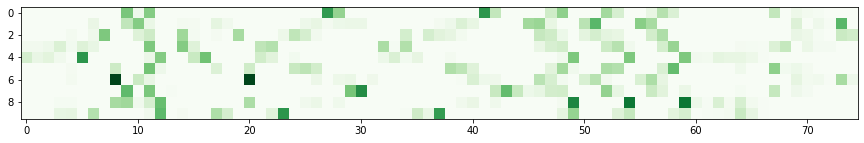

In [14]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(lda_components_norm, cmap='Greens')
display(fig)
plt.close(fig)

In [26]:
print('Top-5 features contributing to lda components')
for i_lda in range(10):
    display(HTML(lda_components_norm.loc[i_lda,:].sort_values(ascending=False).head().to_frame(
                             name='lda_'+str(i_lda)).to_html()))

Top-5 features contributing to lda components


,lda_0
VK_DISTANZ_10.0,0.135246
VK_ZG11_7.0,0.131845
D19_KONSUMTYP_MAX_9,0.092493
ALTERSKATEGORIE_GROB_3,0.086766
CJT_TYP_6_4.0,0.081148


,lda_1
CJT_TYP_5_2.0,0.108249
PRAEGENDE_JUGENDJAHRE_14,0.108174
ALTERSKATEGORIE_GROB_2,0.086620
CJT_TYP_3_1.0,0.083901
CJT_TYP_6_2.0,0.075530


,lda_2
D19_KONSUMTYP_MAX_4,0.090446
D19_KONSUMTYP_1.0,0.073223
D19_KONSUMTYP_6.0,0.067533
CJT_TYP_3_3.0,0.062998
VK_ZG11_4.0,0.052157


,lda_3
ALTERSKATEGORIE_GROB_3,0.090190
D19_KONSUMTYP_1.0,0.087519
CJT_TYP_3_4.0,0.076515
VK_DISTANZ_1.0,0.065748
VK_DISTANZ_3.0,0.061138


,lda_4
D19_KONSUMTYP_MAX_2,0.135947
D19_KONSUMTYP_3.0,0.096891
CJT_TYP_6_5.0,0.091139
CJT_TYP_5_5.0,0.090210
CJT_TYP_3_5.0,0.090162


,lda_5
CJT_TYP_3_4.0,0.103093
ALTERSKATEGORIE_GROB_3,0.095977
PRAEGENDE_JUGENDJAHRE_8,0.081747
CJT_TYP_6_4.0,0.070090
CJT_TYP_5_3.0,0.064667


,lda_6
D19_KONSUMTYP_MAX_8,0.191729
D19_KONSUMTYP_9.0,0.190319
PRAEGENDE_JUGENDJAHRE_14,0.066811
CJT_TYP_3_2.0,0.063707
CJT_TYP_5_2.0,0.057481


,lda_7
VK_ZG11_10.0,0.142558
D19_KONSUMTYP_MAX_9,0.105515
VK_DISTANZ_12.0,0.102771
VK_ZG11_9.0,0.093930
ALTERSKATEGORIE_GROB_3,0.091783


,lda_8
CJT_TYP_3_5.0,0.159889
CJT_TYP_5_5.0,0.159504
CJT_TYP_6_5.0,0.147048
ALTERSKATEGORIE_GROB_4,0.101534
D19_KONSUMTYP_MAX_9,0.072405


,lda_9
VK_ZG11_3.0,0.135612
VK_DISTANZ_6.0,0.130547
ALTERSKATEGORIE_GROB_4,0.105620
CJT_TYP_6_5.0,0.078425
D19_KONSUMTYP_4.0,0.063010


In [27]:
# from gensim.sklearn_api import LdaTransformer
# # Reduce each person to 10 dimensions using the sklearn interface.
# model = LdaTransformer(num_topics=10, 
#                        id2word=id2column, 
#                        iterations=20, alpha='auto', random_state=1)
# #azdias_dimred = model.fit_transform(azdias_ohe.values)
# model.fit(azdias_csr)

In [28]:
azdias_dimred = pd.DataFrame(lda.transform(azdias_ohe.values), index=azdias_ohe.index,
                             columns = ['lda_'+str(i) for i in range(10)])
azdias_dimred.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
LNR,,,,,,,,,,
910215,0.016669,0.016678,0.016670,0.016667,0.016669,0.016667,0.016672,0.016668,0.849973,0.016668
910220,0.012503,0.530454,0.012501,0.012500,0.012500,0.012500,0.012502,0.369539,0.012501,0.012500
910225,0.010002,0.010003,0.010003,0.010002,0.010000,0.010003,0.909984,0.010002,0.010001,0.010000
910226,0.176811,0.010000,0.010001,0.010002,0.010002,0.204682,0.323237,0.010001,0.235261,0.010002
910241,0.011114,0.011112,0.568204,0.011114,0.011111,0.342895,0.011112,0.011114,0.011111,0.011112


In [34]:
#customers_csr = scipy.sparse.csr_matrix(customers_ohe) 
customers_dimred = pd.DataFrame(lda.transform(customers_ohe.values), index=customers_ohe.index,
                             columns = ['lda_'+str(i) for i in range(10)])
customers_dimred.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
LNR,,,,,,,,,,
9626,0.009091,0.009091,0.009092,0.009094,0.918174,0.009091,0.009091,0.009091,0.009093,0.009092
9628,0.016667,0.016667,0.016667,0.016667,0.016668,0.016667,0.016667,0.016667,0.016668,0.849996
143872,0.009091,0.009091,0.009091,0.009091,0.735308,0.009091,0.099331,0.101720,0.009093,0.009092
143873,0.009091,0.009091,0.009091,0.009092,0.918177,0.009091,0.009091,0.009091,0.009093,0.009093
143874,0.009094,0.009091,0.519878,0.407381,0.009094,0.009095,0.009091,0.009094,0.009091,0.009091


In [35]:
azdias_dimred.to_csv('arvato_data/azdias_lda.csv')
customers_dimred.to_csv('arvato_data/customers_lda.csv')

## Clustering

##### K-Means

In [37]:
kmeans_evaluation = pd.DataFrame(columns=['inertia', 
                                          #'silhouette_euclidean', 'silhouette_cosine', # 
                                          'varaince_ratio'], dtype=float)
for k in range(2,16):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=2**13, n_init=7, max_iter=1000)
    kmeans.fit(azdias_dimred)
    #print(k, 'inertia ', kmeans.inertia_)
    kmeans_evaluation.loc[k, 'inertia'] = kmeans.inertia_
    #kmeans_evaluation.loc[k, 'silhouette_euclidean'] = metrics.silhouette_score(azdias_ohe, 
    #                                                                            kmeans.labels_, metric='euclidean')
    #kmeans_evaluation.loc[k, 'silhouette_cosine'] = metrics.silhouette_score(azdias_ohe, 
    #                                                                         kmeans.labels_, metric='cosine')
    kmeans_evaluation.loc[k, 'varaince_ratio'] = metrics.calinski_harabasz_score(azdias_ohe, kmeans.labels_)
display(kmeans_evaluation)

,inertia,varaince_ratio
2,299214.016042,71281.513745
3,263584.624043,53928.636321
4,222474.361904,48314.212596
5,189240.602618,43926.813933
6,164463.286808,35756.438706
7,136685.683061,36122.799546
8,108063.058785,34548.401672
9,87775.095207,33058.368481
10,77261.857104,30676.922156
11,74737.354123,28253.521235


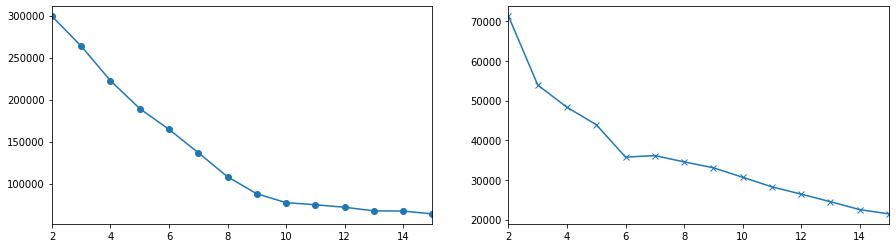

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
kmeans_evaluation['inertia'].plot(marker='o', ax=ax[0], label='inertia');
#kmeans_evaluation['silhouette_euclidean'].plot(marker='x', ax=ax[1]);
#kmeans_evaluation['silhouette_cosine'].plot(marker='o', ax=ax[2]);
kmeans_evaluation['varaince_ratio'].plot(marker='x', ax=ax[1], label='varaince_ratio');
display(fig)
plt.close(fig)

In [40]:
##### Silhouette Coefficient to evaluate the quality of clustering

In [48]:
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=2**13, n_init=7, max_iter=1000)
kmeans.fit(azdias_dimred)

MiniBatchKMeans(batch_size=8192, compute_labels=True, init='k-means++',
                init_size=None, max_iter=1000, max_no_improvement=10,
                n_clusters=10, n_init=7, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [49]:
centers = pd.DataFrame(kmeans.cluster_centers_.round(2), columns=azdias_dimred.columns)
display(centers)

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
0,0.02,0.02,0.03,0.07,0.70,0.04,0.01,0.01,0.03,0.06
1,0.05,0.01,0.02,0.02,0.02,0.04,0.01,0.05,0.73,0.04
2,0.02,0.08,0.69,0.04,0.04,0.05,0.02,0.02,0.02,0.03
3,0.06,0.64,0.07,0.02,0.02,0.03,0.04,0.07,0.01,0.03
4,0.07,0.06,0.02,0.02,0.01,0.06,0.63,0.07,0.02,0.03
5,0.04,0.04,0.05,0.03,0.04,0.59,0.05,0.04,0.07,0.05
6,0.02,0.08,0.02,0.02,0.01,0.05,0.06,0.66,0.05,0.02
7,0.64,0.09,0.02,0.02,0.02,0.02,0.07,0.03,0.06,0.03
8,0.02,0.06,0.08,0.60,0.06,0.04,0.03,0.01,0.03,0.07
9,0.03,0.03,0.07,0.07,0.05,0.08,0.04,0.02,0.08,0.53


Centers just correspond to LDA components

In [43]:
azdias_labels = pd.Series(kmeans.labels_, index=azdias_ohe.index)
azdias_in_group = azdias_labels.value_counts()/azdias_labels.count()
azdias_in_group.sort_index()

0    0.102186
1    0.112028
2    0.087629
3    0.129002
4    0.094953
5    0.088440
6    0.094975
7    0.114767
8    0.088791
9    0.087229
dtype: float64

In [44]:
customers_labels = pd.Series(kmeans.predict(customers_ohe), index=customers_ohe.index)
customers_in_group = customers_labels.value_counts()/customers_labels.count()
customers_in_group.sort_index()

0    0.004905
1    0.337440
2    0.024967
3    0.031380
4    0.003611
5    0.073644
6    0.018252
7    0.139472
8    0.042697
9    0.323633
dtype: float64

In [45]:
percentage_in_group = pd.concat([azdias_in_group, customers_in_group], axis=1)
percentage_in_group.columns=['azdias', 'customers']
percentage_in_group

,azdias,customers
0,0.102186,0.004905
1,0.112028,0.337440
2,0.087629,0.024967
3,0.129002,0.031380
4,0.094953,0.003611
5,0.088440,0.073644
6,0.094975,0.018252
7,0.114767,0.139472
8,0.088791,0.042697
9,0.087229,0.323633


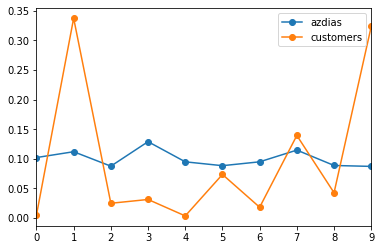

In [46]:
percentage_in_group.plot(marker='o');

##### K-Medoids

In [73]:
import random
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer

#initial_medoids = random.sample(azdias.index.tolist(), 8)
initial_medoids = random.sample(range(len(azdias)), 8)
initial_medoids

[545707, 619932, 433311, 291917, 744719, 384615, 752113, 786896]

In [79]:
from pyclustering.utils.metric import type_metric, distance_metric
from scipy.spatial import distance
#def cosine_dist(p1, p2):
#    return cosine(p1, p2)

cosine_metric = distance_metric(type_metric.USER_DEFINED, func=distance.cosine)

kmedo = kmedoids(azdias_ohe.values, initial_medoids, metric=cosine_metric)

In [81]:
#%%time  # -----  over 90 min
#kmedo.process()

In [ ]:
#medoids = kmedoids_instance.get_medoids()
#
#azdias_clusters = kmedoids_instance.get_clusters()
#
#customers_clusters = kmedoids_instance.predict(customers_ohe)

In [ ]:
# adzias_sample = random.sample(range(len(azdias)), 300)
# clusters, sample = adzias_clusters[adzias_sample], adzias_ohe[adzias_sample,:]

# visualizer = cluster_visualizer();
# visualizer.append_clusters(clusters, sample);
# #visualizer.append_cluster(start_centers, marker = '*', markersize = 20);
# visualizer.append_cluster(medoids, marker = '*', markersize = 20);
# visualizer.show();

##### CURE

In [ ]:
from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.cure import cure;

# Allocate three clusters.
cure_instance = cure(data=azdias_dimred.values, number_cluster=8, number_represent_points=9)


# %%time    # over 90 min
# cure_instance.process()

# azdias_clusters = cure_instance.get_clusters();
# azdias_clusters 

# azdias_representors = cure_instance.get_representors();
# azdias_representors 

# # Visualize allocated clusters.
# visualizer = cluster_visualizer();
# visualizer.append_clusters(azdias_clusters, azdias_dimred.values);
# visualizer.show();

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

##### Read cleaned data

In [56]:
if 'mailout' not in dir():
    mailout = pd.read_pickle('arvato_data/mailout_cleaned.pkl')
print('mailout', mailout.shape)

mailout (42962, 366)


In [57]:
if 'test' not in dir():
    test = pd.read_pickle('arvato_data/test_cleaned.pkl')
print('test',test.shape)

test (42833, 365)


In [58]:
top_categorical_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3']
top_ordinal_columns = ['PRAEGENDE_JUGENDJAHRE']
# 'EXTSEL992'  need further clarification

## Feed-farward neural network with  embeddings for categorical columns

In [ ]:
# Most columns in this data are categorical (even if they are encoded as integers). The simplest and most common way of dealing with categorical data - One-Hot Encoding (OHE) - is not so useful here. 

# * Since each category becomes ist own column, one problem would be significant increased in the number of training features. 

# * Another problem - the significance will also be defined for each category. We will need to extrapolate to each column ourselves

# * One more problem - for ordered columns the OHE approach removes the order of categories 

As a way out, I propose to build a simple feed-forward deep learning model and use 2-dimensional embedding for each column. 

In [93]:
from tensorflow.keras import callbacks, layers, models

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#scalers=dict()
#for colu in top_numerical_columns:
#    scalers[colu] = MinMaxScaler()

I will use 1-dimensional embedding for ordinal columns
For categorical columns, the embedding dimension can be specified per hand for each column.
I wil start with 2-dimensional embeddings

In [66]:
# value of the dictionary is a tuple (number of unique values, desired_output_dimension)
categorical_dict = {colu:(mailout[colu].nunique(), 2) for colu in top_categorical_columns}
print(categorical_dict)
ord_dict = {colu:(mailout[colu].nunique(), 1) for colu in top_ordinal_columns}
print(ord_dict)
cat_ord_dict = categorical_dict.copy()
cat_ord_dict.update(ord_dict)

{'D19_SOZIALES': (6, 2), 'D19_KONSUMTYP_MAX': (6, 2), 'ALTERSKATEGORIE_GROB': (5, 2), 'D19_KONSUMTYP': (8, 2), 'VK_ZG11': (12, 2), 'VK_DISTANZ': (14, 2), 'CJT_TYP_6': (6, 2), 'CJT_TYP_5': (6, 2), 'CJT_TYP_3': (6, 2)}
{'PRAEGENDE_JUGENDJAHRE': (16, 1)}


In [103]:
#ailout['D19_KONSUMTYP_MAX'].value_counts()

2    14297
8     9673
9     7584
1     6366
3     2605
4     2437
Name: D19_KONSUMTYP_MAX, dtype: int64

In [87]:
def create_model(cat_ord_dict, hidden=(32,32), activation='relu'):
    
    assert len(hidden)>0 # at least 1 hidden layers
    
    # ----- embeddings
    input_cat_ord = dict()
    embedding_cat_ord = dict()
    for k, v in cat_ord_dict.items():
        input_cat_ord[k] = layers.Input(shape=(1,), name='input_'+k)
        embedding_cat_ord[k] = layers.Embedding(input_dim=v[0], output_dim=v[1],
                                                name='emb_'+k)(input_cat_ord[k])
        embedding_cat_ord[k] = layers.Flatten(name='emb_flatten_'+k)(embedding_cat_ord[k])
        
    x = layers.Concatenate(name='emb_concatenate')(list(embedding_cat_ord.values()))
    
    # ----- hidden layers
    for i, n in enumerate(hidden[:-1]):
        x = layers.Dense(hidden[i], activation=activation, name='dense_'+str(i))(x)
        x = layers.BatchNormalization(name='bn_'+str(i))(x)
    # ----- last layer without BN
    x = layers.Dense(hidden[-1], activation=activation, name='dense_last')(x)

    # ----- final layer
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = models.Model(inputs=list(input_cat_ord.values()), outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    return model

In [89]:
hidden=(32,32)
activation='relu'
model2h = create_model(cat_ord_dict, hidden=hidden, activation=activation)
model2h.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_D19_SOZIALES (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_D19_KONSUMTYP_MAX (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_ALTERSKATEGORIE_GROB (Inp [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_D19_KONSUMTYP (InputLayer [(None, 1)]          0                                            
____________________________________________________________________________________________

In [97]:
from datetime import datetime

## Prepare input and fit model

Embedding layer requires input with consequtive integers. Since this is not guaranteed in the original data,  I encode all columns

In [105]:
def prepare_input(cat_ord_dict, mailout, test):
    from sklearn.preprocessing import LabelEncoder
    
    encoders = dict()
    input_mailout = list()
    input_test = list()
    
    for colu in cat_ord_dict.keys():
        encoders[colu] = LabelEncoder()
        encoders[colu].fit(mailout[colu])
        input_mailout.append(encoders[colu].transform(mailout[colu]))
        input_test.append(encoders[colu].transform(test[colu]))
        
    return encoders, input_mailout, input_test

In [107]:
encoders, input_mailout, input_test = prepare_input(cat_ord_dict, mailout, test)
#input_mailout

In [114]:
log_dir = 'logs/HIDDEN{:s}_ACTI{:s}_{:%m%d_%H%M}'.format(','.join(str(i) for i in hidden), 
                                                         activation,
                                                         datetime.today())
print(log_dir)
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10, write_graph=False, write_images=True)
#early_cb = callbacks.EarlyStopping

logs/HIDDEN32,32_ACTIrelu_0324_1147


In [115]:
hist = model2h.fit(x=input_mailout, y=mailout['RESPONSE'].values,
                   epochs=50, verbose=2, batch_size=2**10,
                   callbacks=[tb_cb],
                   validation_split=0.3, shuffle=True) 

Train on 30073 samples, validate on 12889 samples
Epoch 1/50
30073/30073 - 0s - loss: 0.0613 - AUC: 0.7844 - val_loss: 0.1772 - val_AUC: 0.7456
Epoch 2/50
30073/30073 - 0s - loss: 0.0611 - AUC: 0.7860 - val_loss: 0.1555 - val_AUC: 0.7519
Epoch 3/50
30073/30073 - 0s - loss: 0.0609 - AUC: 0.7894 - val_loss: 0.1310 - val_AUC: 0.7513
Epoch 4/50
30073/30073 - 0s - loss: 0.0606 - AUC: 0.7946 - val_loss: 0.1153 - val_AUC: 0.7600
Epoch 5/50
30073/30073 - 0s - loss: 0.0603 - AUC: 0.7974 - val_loss: 0.0991 - val_AUC: 0.7566
Epoch 6/50
30073/30073 - 0s - loss: 0.0603 - AUC: 0.7990 - val_loss: 0.0862 - val_AUC: 0.7548
Epoch 7/50
30073/30073 - 0s - loss: 0.0601 - AUC: 0.8024 - val_loss: 0.0774 - val_AUC: 0.7507
Epoch 8/50
30073/30073 - 0s - loss: 0.0601 - AUC: 0.8007 - val_loss: 0.0729 - val_AUC: 0.7456
Epoch 9/50
30073/30073 - 0s - loss: 0.0600 - AUC: 0.8030 - val_loss: 0.0652 - val_AUC: 0.7467
Epoch 10/50
30073/30073 - 0s - loss: 0.0601 - AUC: 0.7988 - val_loss: 0.0633 - val_AUC: 0.7461
Epoch 11/

## Predict test

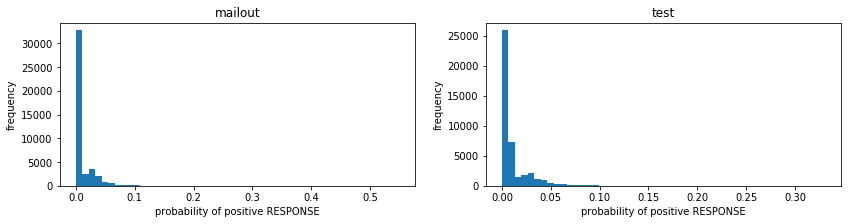

In [120]:
mailout_prediction = model2h.predict(x=input_mailout)
test_prediction = model2h.predict(x=input_test)

#mailout_prediction[:5]

fig, ax = plt.subplots(1,2, figsize=(14,3))
ax[0].hist(mailout_prediction.flatten(), bins=50)
ax[0].set_title('mailout')
ax[0].set_ylabel('frequency')
ax[0].set_xlabel('probability of positive RESPONSE')
#
ax[1].hist(test_prediction.flatten(), bins=50)
ax[1].set_title('test')
ax[1].set_ylabel('frequency')
ax[1].set_xlabel('probability of positive RESPONSE')
display(fig)
plt.close(fig)

# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')